# Spectral Line Data Cubes in Astronomy - Part 1 

In this notebook we will introduce spectral line data cubes in astronomy. They are a convenient way to store many spectra at points in the sky. Much like having a spectrum at every pixel in a CCD. In this Part 1 we will keep it as much "pure python", and not use astronomical units and just work in "pixel" or "voxel" space.   In Part2 we will repeat the process with a more astronomy rich set of modules that you will have to install.

They normally are presented as a [FITS](https://en.wikipedia.org/wiki/FITS) file, with two sky coordinates (often Right Ascension and Declination) and one spectral coordinate (either an observing frequency or wavelength, and when there is a known spectral line, you can reference using this line with a velocity using the doppler effect). For radio data, such as ALMA and the VLA, we often use frequency, in GHz or MHz. For optical data we often use the wavelength, in Angstrom (the visible range is around 4000 - 8000 Angstrom, or 400 - 800 nm).

![Example Cube](../../../data/cube_dims_and_cell.png "just an example cube")
## Outline

**Main Goal:** To introduce the concepts of spectral line data cubes

- Definition of image cube
- Data representation image cube
- Introduction to galaxy rotating disks

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

This first line of code is actually not real python code, but a magic ipython command, to make sure that the standard plotting commands are going to be displayed within the browser. You will see that happen below. The cube figure about is just a static PNG file.

As we will progress learning about the data and how to explore it further, you will notice this decision making process  throughout this notebook..

## 1. Reading the data

In [2]:
import numpy as np
import math
from astropy.io import fits

The [astropy](http://www.astropy.org/) package has an I/O package to simplify reading and writing a number of popular formats common in astronomy. 

In [3]:
hdu = fits.open('data/ngc6503.cube.fits')
print(len(hdu))
print(hdu[0])
print(hdu[1])

2


A FITS file consists of a series of Header-Data-Units (HDU). Usually there is only one, representing the image. But this file has two. For now, we're going to ignore the second, which is a special table and in this example happens to be empty anyways.  Each HDU has a header, and data.  The data in this case is a numpy array, and represents the image (cube):

In [4]:
h = hdu[0].header
d = hdu[0].data
print(d.shape, d.min(), d.max(), d.mean(), np.median(d), d.std())
print("Signal/Noise  (S/N):",d.max()/d.std())


(1, 89, 251, 371) -0.00315721 0.0169835 4.73436e-05 1.33753e-05 0.000740354
Signal/Noise  (S/N): 22.9397


From the shape (1,89,251,371) we can see this image is actually 4 dimensional, although the 4th dimension is dummy.  There are 371 pixels along X, 251 along Y, and 89 slices or spectral channels. It looks like the noise is around 0.00073 and a peak value 0.017, thus a signal to noise of a little over 23, so quite strong.

In python you can remove that dummy 4th axis, since we are not going to use it any further. Otherwise we have to keep addressing this dummy 4th axis.

In [5]:
# printing out the (dictionary) header:
print(h.keys)

<bound method Header.iterkeys of SIMPLE  =                    T /                                                
BITPIX  =                  -32 /                                                
NAXIS   =                    4 /                                                
NAXIS1  =                  371 /                                                
NAXIS2  =                  251 /                                                
NAXIS3  =                   89 /                                                
NAXIS4  =                    1 /                                                
EXTEND  =                    T /Tables following main image                     
BLOCKED =                    T /Tape may be blocked                             
OBJECT  = 'NGC6503 '                                                            
TELESCOP= 'VLA     '                                                            
INSTRUME= 'VLA     '                                                        

In [6]:
# for example we can thus get the value for one of those header variables:
print('crval3   =',h['CRVAL3'])
print('restfreq =',h['RESTFREQ'])

crval3   = 1420275901.66
restfreq = 1420405752.0


In [7]:
d = d.squeeze()
print(d.shape)
# nz=d.shape[0]

(89, 251, 371)


In case you were wondering about that 4th redundant axis. In astronomy we sometimes observe more than one type of radiation. Since waves are polarized, we can have up to 4 so called Stokes parameters, describing the waves as e.g. linear or circular polarized radiation.  We will ignore that here, but they are sometimes stored in that 4th dimension. Sometimes they are stored as separate cubes. YMMV.

## 2. Plotting some basics

(251, 371)


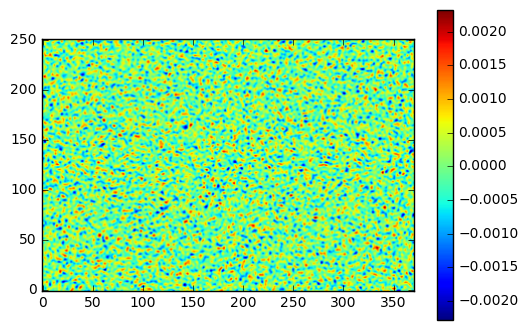

In [8]:
z = 38      # pick a channel (z from the XYZ cube)
z = 45         # the mystery blob
z = 0
im = d[z,:,:]  #   im = d[z]     also works
#im = d[z, 50:110, 210:270]      # how to select a sub region
#im = d[z, 100:150, 140:180]
plt.imshow(im,origin=['Lower'])
plt.colorbar()
print(im.shape)

There are 89 channels (slices) in this cube, numbered 0 through 88 in the usual python sense. Pick a few other slices by changing the value in 
**z=** and notice that the first few and last few appear to be just noise and that the V-shaped signal changes shape through the channels. Perhaps you should not be surprised that these are referred to as butterfly diagrams.

(8287769,)


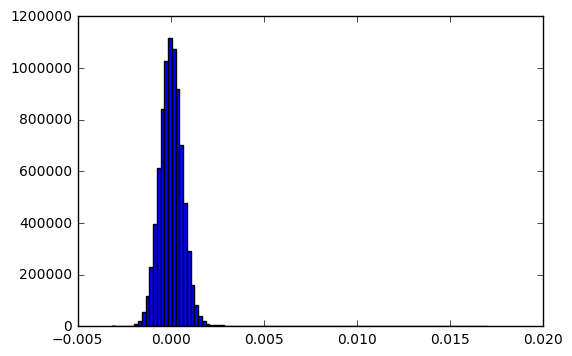

In [ ]:
# look at a histogram of all the data (histogram needs a 1D array)
d1 = d.ravel()                 # ravel() doesn't make a new copy of the array, saving memory
print(d1.shape)
(n,b,p) = plt.hist(d1, bins=100)

Notice that the histogram is on the left in the plot, and we already saw the maximum data point is 0.0169835.

So let us plot the vertical axis logarithmically, so we can better see what is going on.

In [ ]:
(n,b,p) = plt.hist(d1,bins=100,log=True)

In [ ]:
# pick a slice and make a histogram and print the mean and standard deviation of the signal in that slice
z=0
imz = d[z,:,:].flatten()
(n,b,p) = plt.hist(imz,bins=100)
print(imz.mean(), imz.std())


**Exercise** : observe by picking some values of **z** that the noise seems to vary a little bit from one end of the band to the other.  Store the noise in channel 0 and 88 in variables sigma0 and sigma88:


## 3. Statistics

Now that we have computed the RMS in a channel, we might as well compute them for all channels!

We are also comparing this channel based RMS with the single cube RMS that we determined earlier.

In [ ]:
nchan = d.shape[0]
channel = np.arange(nchan)
rms = np.zeros(nchan)
peak = np.zeros(nchan)
cuberms = np.zeros(nchan) + d.std()
for z in range(nchan):
    imz = d[z,:,:].flatten()
    rms[z] = imz.std()
    peak[z] = imz.max()
plt.plot(channel,rms,label='chan_rms')
#plt.plot(channel,peak,label='peak')
plt.plot(channel,cuberms,label='cube_rms',color='black')
plt.legend(loc='best')
plt.xlabel("Channel")
plt.ylabel("RMS")
plt.title("Noise for each channel")

**Question:**  can you think of a better way to compute the RMS as function of channel (the blue line) and *not* have it depend so much on where there is signal?



In [ ]:
# helper function for slice statistics
import numpy.ma as ma
def robust(d, method=0, ns=4.0, rf=1.5):
    if method==0:
        return d.std()
    elif method==1:
        m = d.mean()
        s = d.std()
        d1 = ma.masked_outside(d,m-ns*s,m+ns*s)
        return d1.std()
    elif method==2:
        # assume mean is close enough to zero and no absorbtion
        m = d.min()
        d1 = ma.masked_outside(d,m,-m)
        return d1.std()
    elif method==3:
        n = len(d)
        d.sort()
        q1 = d[n//4]
        q3 = d[(3*n)//4]
        D = q3-q1
        d1 = ma.masked_outside(d,q1-rf*D,q3+rf*D)
        return d1.std()
    else:
        return d.std()
    

In [ ]:
nchan = d.shape[0]
channel = np.arange(nchan)
rms0 = np.zeros(nchan)
rms1 = np.zeros(nchan)
rms2 = np.zeros(nchan)
rms3 = np.zeros(nchan)
rms4 = np.zeros(nchan)
rms5 = np.zeros(nchan)
peak = np.zeros(nchan)
cuberms = np.zeros(nchan) + d.std()
for z in range(nchan):
    imz = d[z,:,:].flatten()
    imz4 = d[z,0:80,280:355].flatten()
    imz5 = d[z,170:250,0:120].flatten()
    rms0[z] = robust(imz,0)
    rms1[z] = robust(imz,1,ns=4.0)
    rms2[z] = robust(imz,2)
    rms3[z] = robust(imz,3,rf=1.5)
    rms4[z] = robust(imz4,0)
    rms5[z] = robust(imz5,0)
    peak[z] = imz.max()
plt.plot(channel,rms0,label='chan_rms0')
plt.plot(channel,rms1,label='chan_rms1')
plt.plot(channel,rms2,label='chan_rms2')
plt.plot(channel,rms3,label='chan_rms3')
plt.plot(channel,rms4,label='chan_rms_lr')
plt.plot(channel,rms5,label='chan_rms_tl')
# plt.plot(channel,peak,label='peak')
plt.plot(channel,cuberms,label='cube_rms',color='black')
plt.legend(loc='best',fontsize='small')
plt.xlabel("Channel")
plt.ylabel("RMS")
plt.savefig("n6503_rms.png")



Next we are interested in the Signal/Noise per channel where is there is no signal. This is clear in the first few and last channels. Recall that in the absence of real signal the peak will always be a few times sigma, purely based on the error function behavior of the distribution of gaussian noise. In our case something like $4\sigma$. For small maps more like $3\sigma$, for really big maps or cubes $5\sigma$.

In [ ]:
n0 = 15    # the first few channels
n1 = 13    # the last few channels
rms0 = rms[:n0].mean()
rms1 = rms[-n1:].mean()
cuberms = np.zeros(nchan) + 0.5*(rms0+rms1)
sn0 = peak/rms0
sn1 = peak/rms1
plt.plot(channel,sn0,label='S/N(low)')
plt.plot(channel,sn1,label='S/N(high)')
plt.plot(channel[:n0],np.zeros(n0)+1,color='black',label='edge')
plt.plot(channel[-n1:],np.zeros(n1)+1,color='black')
plt.legend(loc='best')
print(rms0,rms1)

In [ ]:
s1=peak[0:15]/rms[0:15]
s2=peak[75:88]/rms[75:88]
print("First few channels:",s1.mean(),s1.std())
print("Last  few channels:",s2.mean(),s2.std())

Gaussian noise probability distribution is given by
$$
P(x) =  { 1 \over {\sigma \sqrt{2\pi}}} {e^{- { x^2 \over {2 \sigma^2}}}}
$$
where the mean is 0 and RMS is $\sigma$. This function is normalized, integrated over *x* results in 1.

Lets do a simulation to see if we can understand the S/N in this plot. We will need the error function to compute the chance of being in the tail part of the gaussian. The error function is defined as:
$$
erf(x) =  { {2}\over{\sqrt{\pi}}}      \int_0^x  e^{-t^2} dt
$$

In [ ]:
def pnoise(n):
    """ chance of measuring noise of n * sigma"""
    return 0.5*math.erfc(n/math.sqrt(2.0))

nsample = 10000
g = np.random.normal(size=nsample)
sn = g.max()/g.std()
print("S/N: ",sn)
print("1/P(S/N)=",1/pnoise(sn))

In [ ]:
# 1/chance for a +1,2,3 sigma detection
print(1/pnoise(1.0))
print(1/pnoise(2.0))
print(1/pnoise(3.0))
print(1/pnoise(4.0))
print(1/pnoise(5.0))
nxy = d.shape[1]*d.shape[2]
print("Number of pixels in a map:",nxy)

In [ ]:
peakpos = (175,125)     # some strong point in the disk of the galaxy
peakpos = (231,80)     # the mystery blob?
#peakpos = (310,50)      # no signal
spectrum = d[:,peakpos[1],peakpos[0]]
sns = spectrum.max()/rms[0:15].mean()
zero = spectrum * 0.0
plt.plot(channel,spectrum,'o-',markersize=2)
plt.plot(channel,zero)
plt.plot(channel,cuberms,'r--',label='1$\sigma$')
plt.plot(channel,-cuberms,'r--')
plt.title("Spectrum at position %s  S/N=%.3g" % (str(peakpos),sns))
plt.legend();

Is the noise correlated? Hanning smoothing is often used to increase the S/N. Test this by taking the differences between neighboring signals and computing the RMS of this "signal". If noise is normal and not correllated, the ratio of this RMS to the original RMS of the signal should be $\sqrt{2}$. Pick a point where there is no obvious signal, such as the (310,50) position.

In [ ]:
cdelt3 = h['CDELT3']
crval3 = h['CRVAL3']
crpix3 = h['CRPIX3']
restfreq=h['RESTFREQ']
freq = (channel+1-crpix3)*cdelt3 + crval3   # at the ref. pixel we get the ref. value
c = 299792.458                              # speed of light in km/s
channelv = (1.0-freq/restfreq) * c          # convert to doppler velocity in km/s
print("min/max/dv:",channelv[0],channelv[nchan-1],channelv[0]-channelv[1])
plt.plot(channelv,spectrum,'o-',markersize=2)
plt.plot(channelv,zero)
plt.plot(channelv,cuberms,'r--',label='1$\sigma$')
plt.plot(channelv,-cuberms,'r--')
plt.title("Spectrum at position %s  S/N=%.3g" % (str(peakpos),sns))
plt.legend()
plt.xlabel("velocity (km/s)");

In [ ]:
# saving a descriptive spectrum using pickle
try:
    import cPickle as pickle
except:
    import pickle
   
# construct a descriptive spectrum 
sp = {}
sp['z'] = channelv
sp['i'] = spectrum
sp['zunit'] = 'km/s'
sp['iunit'] = h['BUNIT'] 
sp['xpos']  = peakpos[0]
sp['ypos']  = peakpos[1]
    
# write it
pfile = "n6503-sp.p" 
pickle.dump(sp,open(pfile,"wb"))
print("Wrote spectrum",pfile)

In [ ]:
dspectrum = spectrum[1:] - spectrum[:-1]
# dspectrum = np.diff(spectrum)                      # this also works (but look up documentation!)
rms1 = dspectrum.std()
rms0 = spectrum.std()
print(rms1,"/",rms0,"=",rms1/rms0)

The ratio of the noise you see here should be $\sqrt{2}$, but let's see for a typical normal distribution how close we are to $\sqrt{2}$:

In [ ]:
%%time 
nsample = 100000
g = np.random.normal(10.0,5.0,nsample)
delta = np.diff(g)
gh=plt.hist([g,delta],32)
print(g.std(),delta.std(),delta.std()/g.std()/math.sqrt(2))

## 4. Smoothing a cube to enhance the signal to noise

In [ ]:
import scipy.signal
import scipy.ndimage.filters as filters

In [ ]:
z = 0
sigma = 2.0
ds1 = filters.gaussian_filter(d[z],sigma)         # ds1 is a single smoothed slice
print("new mean/std:", ds1.mean(), ds1.std())
print("old mean/std:", d[z].mean(),d[z].std())
plt.imshow(ds1,origin=['Lower'])
plt.colorbar();

Notice that the noise is indeed lower than your earlier value of sigma0.   We only smoothed one single slice, but we actually need to smooth the whole cube.  Each slice  with sigma, but we can optionally also smooth in the spectral dimension a little bit. Since we have 89 channels, lets smooth by only 1 (FWHM = 2.355 * sigma)

In [ ]:
ds = filters.gaussian_filter(d,[1.0,sigma,sigma])        # ds is now a smoothed cube 
plt.imshow(ds[z],origin=['Lower'])
plt.colorbar()
print(ds[z].std())
print(ds.max(),ds.max()/ds1.std())

Notice that, although the peak value was lowered a bit due to the smoothing, the signal to noise has increased from the original cube. So, the signal should stand out a lot better.

**Exercise** : Observe a subtle difference in the last two plots. Can you see what happened here?

## 5. Masking


In [ ]:
import numpy.ma as ma

In [ ]:
#  sigma0 is the noise in the original cube
sigma0 = rms0
nsigma = 0.0
dm = ma.masked_inside(d,-nsigma*sigma0,nsigma*sigma0)
print("Percentage of unmasked voxels:",dm.count()/len(d.ravel()) * 100)

In [ ]:
mom0 = dm.sum(axis=0)
plt.imshow(mom0,origin=['Lower'])
plt.colorbar()
#
(ypeak,xpeak) = np.unravel_index(mom0.argmax(),mom0.shape)
print("PEAK at location:",xpeak,ypeak,mom0.argmax())

In [ ]:
spectrum1 = d[:,ypeak,xpeak]
spectrum2 = ds[:,ypeak,xpeak]
plt.plot(channel,spectrum1)
plt.plot(channel,spectrum2)
plt.plot(channel,zero)

In [ ]:
mom0s = ds.sum(axis=0)
plt.imshow(mom0s,origin=['Lower'])
plt.colorbar()

## 6. Velocity fields

The mean velocity is defined as the first moment

$$
<V> = {\Sigma{(v.I)} \over \Sigma{(I)} }
$$

also known as an intensity weighted mean velocity

In [ ]:
nz = d.shape[0]
vchan = np.arange(nz).reshape(nz,1,1)
vsum = vchan * d
vmean = vsum.sum(axis=0)/d.sum(axis=0)
print("MINMAX",vmean.min(),vmean.max())
plt.imshow(vmean,origin=['Lower'],vmin=0,vmax=88)
#plt.imshow(vmean,origin=['Lower'])
plt.colorbar();

Although we can recognize an area of coherent motions (the red and blue shifted sides of the galaxy), there is a lot of noise in this image. Looking at the math, we are dividing two numbers, both of which can be noise, so the outcome can be "anything".  If anything, it should be a value between 0 and 88, so we could mask for that and see how that looks.

Let us first try to see how the smoothed cube looked.

In [ ]:
nz = ds.shape[0]
vchan = np.arange(nz).reshape(nz,1,1)
#vchan = channelv.reshape(nz,1,1)
vsum = vchan * ds
vmean = vsum.sum(axis=0)/ds.sum(axis=0)
print(vmean.shape,vmean.min(),vmean.max())
plt.imshow(vmean,origin=['Lower'],vmin=0,vmax=88)
plt.colorbar()

Although more coherent, there are still bogus values outside the image of the galaxy. So we are looking for a hybrid of the two methods.  In the smooth cube we saw the signal to noise is a lot better defined, so we will define areas in the cube where the signal to noise is high enough and use those in the original high resolution cube.

In [ ]:
# this is all messy , we need a better solution, a hybrid of the two:
noise = ds[0:5].flatten()
(n,b,p) = plt.hist(noise,bins=100)
print(noise.mean(), noise.std())

In [ ]:
sigma0 = noise.std()
nsigma = 5.0
cutoff = sigma0*nsigma
dm = ma.masked_inside(ds,-cutoff,cutoff)    # assumes mean is close to 0
print(cutoff,dm.count())

In [ ]:
dm2=ma.masked_where(ma.getmask(dm),d)

In [ ]:
vsum = vchan * dm2
vmean = vsum.sum(axis=0)/dm2.sum(axis=0)
print("min/max velocity:",vmean.min(),vmean.max())
plt.imshow(vmean,origin=['Lower'],vmin=0,vmax=88)
plt.colorbar()
# some guess of where the major axis of the galaxy is
#s = [50,55,300,205]
#plt.plot([s[0],s[2]],[s[1],s[3]], 'k-', lw=2)
# print(vmean.shape)

And voila, now this looks a lot better, although only velocies between 0 and 88 are possible. Any other values are no doubt due to a noisy division of two numbers.  Experiment with a different value of **nsigma** here.

We need to do one final correction: the velocity field is in channels, not in km/s...  In a previous cell we created an array **channelv** which are the doppler shifted velocities in each of these channels:

In [ ]:
print(channelv[0],channelv[88])

This also means the first channel is the red-shifted (receding) side. So the colors in the previous plot are "wrong"!

## Saving your output

This result is now stored in the **vmean** numpy array. But how do we make this information persistent?

The answer is again in FITS format. Where the **fits.open()** function would retrieve a Header and Data 
(or series of), we need to construct a Header with this Data and write it using **fits.writeto()**. 

In [ ]:
# the old hdu[0] is still available, but points to a 3D cube, so lets just try and make it 2D
hv = h.copy()
hv['NAXIS'] = 2
#   cannot write yet: complains about illegal axes
hv.remove('NAXIS3')
hv.remove('NAXIS4')
print(type(vmean))
print(vmean.shape)
print(h['BITPIX'])
#   cannot write yet: complains about masking
vmean0 = ma.filled(vmean,0.0)
#   finally write it successfully
fits.writeto('n6503-vmean.fits',vmean0,hv,clobber=True)

## Rotation Curves

The simplest way perhaps is to measure the velocities along the major axis. Here's a simple way to extract it along the whole major axis, using interpolation

In [ ]:
import scipy.ndimage

s = [20,30,300,210]     # define a line from (x0,y0) to (x1,y1)
x0, y0 = s[0],s[1]
x1, y1 = s[2],s[3]
num = 200
x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)
z = scipy.ndimage.map_coordinates(np.transpose(vmean), np.vstack((x,y)))
plt.imshow(vmean,origin=['Lower'],vmin=0,vmax=88)
plt.plot([x0, x1], [y0, y1], 'ro-')
plt.colorbar()
plt.title("Velocity field with slice");

In [ ]:
plt.plot(x,z);
plt.title("Slice along the major axis");

### Receding and Approaching rotation curve

And here the version of a rotation curve along the receding and approaching sides. This is generally a better idea, not only to get an idea if the two sides are compatible.

N6503, according to http://ned.ipac.caltech.edu/ is located at 17h49m26.4s +70d08m40s 

We can either use ds9 to use the cursor at this RA/DEC and read off the pixel value (but we should note each pixel is 4") 

By zooming in a bit I got about :  163.4  123.1

This is based on the first pixel in the lower left of the image being (1,1)

For python we need a (0,0) based system, so this would be (162.3,122.1)

In [ ]:
#   here is the reference pixel, which you will see is not where the galaxy is
c1=h['crpix1']
c2=h['crpix2']
pixel_size = h['cdelt2']*3600.0
print(c1,c2,pixel_size)

In [ ]:
import scipy.ndimage

center = [163.5,123.2]   # orig: 5.4
center = [164.5,124.2]  #  10
center = [162.5,122.2]     #  wow, about same
center = [161.5,121.2]
center = [162.3,122.1]
length = 150               # in pixels
pa     = 119.9             # in degrees
cosp = math.cos(pa*math.pi/180.0) 
sinp = math.sin(pa*math.pi/180.0) 
x0,y0 = center
#
x1 = x0 - length * sinp         # blue shifted side 
y1 = y0 + length * cosp
x2 = x0 + length * sinp         # red shifted side
y2 = y0 - length * cosp
num = length
x1s, y1s = np.linspace(x0, x1, num), np.linspace(y0, y1, num)
x2s, y2s = np.linspace(x0, x2, num), np.linspace(y0, y2, num)
r = np.arange(num)*pixel_size
z1 = scipy.ndimage.map_coordinates(np.transpose(vmean), np.vstack((x1s,y1s)))
z2 = scipy.ndimage.map_coordinates(np.transpose(vmean), np.vstack((x2s,y2s)))
plt.imshow(vmean,origin=['Lower'],vmin=0,vmax=89)
plt.colorbar()
plt.plot([x0, x1], [y0, y1], 'ro-')     # blue shifted
plt.plot([x0, x2], [y0, y2], 'bo-')     # red shifted
plt.plot([c1,c1],[c2,c2],'yo-')         # peakpos
plt.title("velocity field");
print(x1,y1)

In [ ]:
plt.plot(r,z1,c='b')
plt.plot(r,z2,c='r')

In [ ]:
vsys = 28.5
v1 = z1 - z1[0]
v2 = z2[0]-z2
print("Vsys (literature) = ",vsys)
print("Offsets: v1,v2=",z1[0],z2[0])
plt.plot(r,abs(v1),c='b')
plt.plot(r,abs(v2),c='r')
iflat = 50
print(v1[iflat:].mean(), v1[iflat:].std())
print(v2[iflat:].mean(), v2[iflat:].std())
print(v1[iflat:].mean()-v2[iflat:].mean())

Compare these two rotation curves with Figure 12 in the Greisen et al. (2009) paper:
![fig12](data/fig12.png "Fig12 from Greisen et al (2009)")

In [ ]:
# replotting to compare with figure 12
# fold in the inclination, since observations get v * sin(i)
inc = 75.1
sini = math.sin(inc * math.pi/180)
#
plt.plot(r,abs(v1)/sini,c='b')
plt.plot(r,abs(v2)/sini,c='r')
plt.xlim(0,950)
plt.ylim(88,132)
plt.xlabel("Radius (arcsec)")
plt.ylabel("Rotation Velocity (km/s)")
plt.title("Comparing with Greisen et al. Figure 12");

# Epilogue

Some of the pure python constructs that we discussed here, notably masking and smoothing, become cumbersome. Also the absence of astronomical units (instead of pixels) can be cumbersome. In the advanced case we will use some community developed code that makes working with such spectral line image cubes a lot easier. For the particular problem of rotation curves there are also many non-python solutions available, see the ASCL based list below. 
  
## ASCL

The is an online registry, [ASCL](http://ascl.net), where you can search for astrophysics codes. For example, to analyse velocity fields to extract rotation curves there are several:

* [NEMO](http://ascl.net/1010.051) look for the **rotcur** program
* [GIPSY](http://ascl.net/1109.018) look for the **rotcur** program
* [AIPS](http://ascl.net/9911.003) look for the **CUBIT** and **GAL** programs
* [TiRiFiC](http://ascl.net/1208.008) uses GIPSY, 3D fit
* [FAT](http://ascl.net/1507.011) TiRiFiC was deemed hard to use, so this is a frontend to make it automated
* [3D-Barolo](http://ascl.net/1507.001) 3D fit
* [velfit](http://ascl.net/1010.021) fitting a velocity field
* [diskfit](http://ascl.net/1209.011) fitting a velocity field as well as mass (light) distribution


## Papers

The data cube we have used in this notebook has been provided by Eric Greisen (NRAO), and his 2009 paper discussed results in detail: 
http://adsabs.harvard.edu/abs/2009AJ....137.4718G

Data are also available on Greisen's [ftp](ftp://ftp.aoc.nrao.edu/staff/egreisen/)


# Epilogue

Some of the pure python constructs that we discussed here, notably masking and smoothing, become cumbersome. In the advanced case we will use some community developed code that makes working with such spectral line image cubes a lot easier. Thing that come to mind are:
* WCS (astronomical coordinate systems)
* units (the flux unit in radio astronomy is Jy/beam)
* arbitrary slices through the cube
